In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats

Parameters

In [2]:
S_0 = 100
sigma = 0.3
r = 0.05
b = 0.05
T = 2
n = 9

## Problem 1

In [3]:
def g(s, K):
    return max(s - K, 0)

In [4]:
def binom(n, k):
    return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

In [5]:
def Sn(S_0, T, n, b, sigma, j):
    # n > 0, T > 0
    h_n = T/n
    u = np.exp(b*h_n + sigma*np.sqrt(h_n))
    d = np.exp(b*h_n - sigma*np.sqrt(h_n))
    S_nj = [S_0*(u**(j-i))*(d**i) for i in range(j+1)]
    return S_nj

In [6]:
def Payoffn(S_0, T, n, b, sigma, K):
    return [g(s,K) for s in Sn(S_0, T, n, b, sigma, n)]

In [7]:
def Calln(S_0, T, n, r, b, sigma, K):
    if n == 0:
        return g(S_0, K)
    h_n = T/n
    u = np.exp(b*h_n + sigma*np.sqrt(h_n))
    d = np.exp(b*h_n - sigma*np.sqrt(h_n))
    q_n = (np.exp(r*h_n) - d)/(u - d)
    return np.exp(-r*T)*sum([Payoffn(S_0,T,n,b,sigma,K)[n-j] * binom(n,j) * (q_n**j) * (1 - q_n)**(n-j) for j in range(n+1)])

To get an option price at an arbitrary time and then calculate the hedging coefficients, we use Calln() with adjusted T, S_0 and n

In [8]:
def Deltan(S_0, T, n, r, b, sigma, K, j):
    h_n = T/n
    u = np.exp(b*h_n + sigma*np.sqrt(h_n))
    d = np.exp(b*h_n - sigma*np.sqrt(h_n))
    S_nj = Sn(S_0,T,n,b,sigma,j)
    return [(Calln(s*u,(n-j-1)*T/n,n-j-1,r,b,sigma,K) - Calln(s*d,(n-j-1)*T/n,n-j-1,r,b,sigma,K))/((u-d)*s) for s in S_nj]

Plot call prices at time zero

In [9]:
K_values = list(range(10, 150))
call_prices = []
for K in K_values:
    call_prices.append(Calln(S_0, T, n, r, b, sigma, K))

Text(0.5, 1.0, 'Cox-Ross-Rubenstein model')

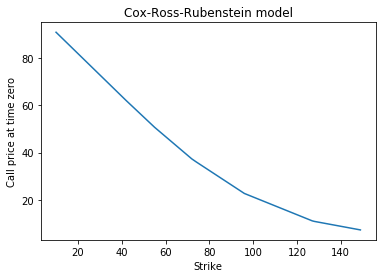

In [10]:
plt.plot(K_values, call_prices)
plt.xlabel("Strike")
plt.ylabel("Call price at time zero")
plt.title("Cox-Ross-Rubenstein model")

As expected, the call prices decrease with the strike, together with its intrinsic value (given by $S_t - K$ at any time $t$). Any inversion of this behaviour would be absurd, as it would allow an evident arbitrage.

Plot min and max strategy coefficient values for different strikes

In [11]:
Deltan(S_0=100, T=2, n=10, r=0.05, b=0.05, sigma=0.3, K=110, j=7)

[1.0000000000000002,
 1.0,
 0.9999999999999999,
 0.786695867155126,
 0.29450829616623453,
 0.005658358289679882,
 0.0,
 0.0]

In [12]:
K_values = list(range(80, 121, 10))
deltas = []
for K in K_values:
    deltas.append([Deltan(S_0, T, n, r, b, sigma, K, j) for j in range(n)])

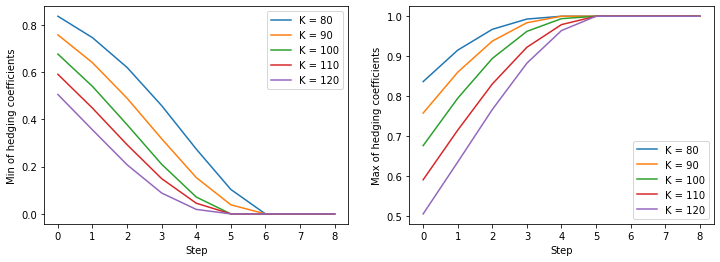

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

for i, K in enumerate(K_values):
    mins = []
    for j, d in enumerate(deltas[i]):
        mins.append(min(d))
    ax1.plot(list(range(n)), mins)
ax1.legend([f"K = {k}" for k in K_values])
ax1.set_xlabel("Step")
ax1.set_ylabel("Min of hedging coefficients")

for i, K in enumerate(K_values):
    maxs = []
    for j, d in enumerate(deltas[i]):
        maxs.append(max(d))
    ax2.plot(list(range(n)), maxs)
ax2.legend([f"K = {k}" for k in K_values])
ax2.set_xlabel("Step")
ax2.set_ylabel("Max of hedging coefficients")

plt.show()

We notice that calls with a small strike relatively to the underlying value, that is, deep in the money (ITM) calls, have a delta value very close to 1, since every movement in the underlying price is almost entirely reproduced on the call price. Similarly, higher strikes yield smaller delta, that is, less exposure to the risky asset.

Let's make heatmaps with the strategy deltas for 5 different values of K for the first 10 steps

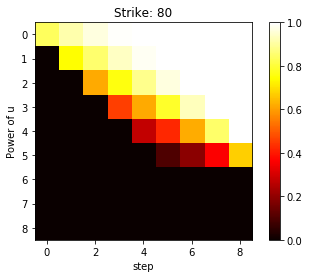

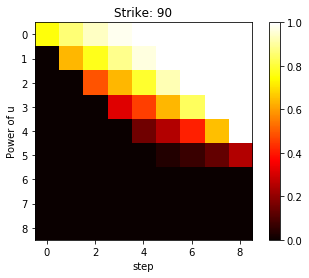

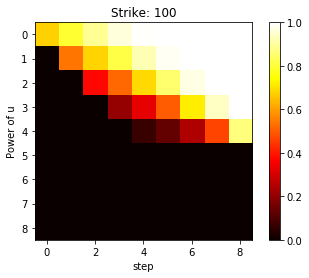

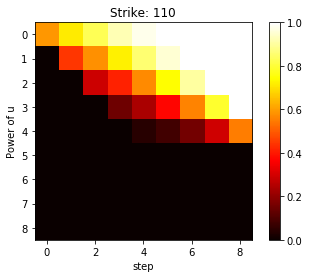

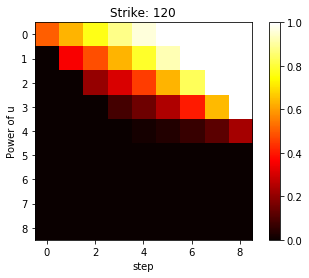

In [14]:
for i, K in enumerate(K_values):
    deltas_matrix = np.zeros((n,n))
    for j in range(n):
        deltas_matrix[:,j][:len(deltas[i][j])] = np.array(deltas[i][j])
    plt.imshow(deltas_matrix[:10,:10], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.xlabel("step")
    plt.ylabel("Power of u")
    plt.title(f"Strike: {K}")
    
    plt.show()


## Problem 2

In [15]:
def d_plus(s,k,v):
    return math.log(s/k)/math.sqrt(v) + math.sqrt(v)/2

def d_minus(s,k,v):
    return math.log(s/k)/math.sqrt(v) - math.sqrt(v)/2

def Call(S_0, T, r, sigma, K):
    K_disc = K*np.exp(-r*T)
    return S_0 * stats.norm.cdf(d_plus(S_0,K_disc,(sigma**2)*T)) - K_disc * stats.norm.cdf(d_minus(S_0,K_disc,(sigma**2)*T))

Black-Scholes prices

In [16]:
call_prices = []
for K in K_values:
    call_prices.append(Call(S_0, T, r, sigma, K))

Text(0.5, 1.0, 'Black-Scholes model')

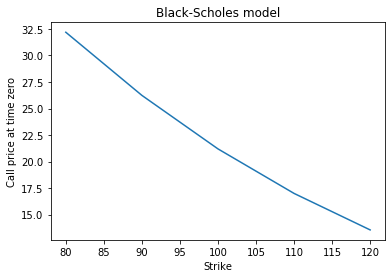

In [17]:
plt.plot(K_values, call_prices)
plt.xlabel("Strike")
plt.ylabel("Call price at time zero")
plt.title("Black-Scholes model")

Relative error

In [18]:
def err(T, n, r, b, sigma, K):
    return Calln(S_0, T, n, r, b, sigma, K) / Call(S_0, T, r, sigma, K) - 1

Text(0, 0.5, 'Relative error')

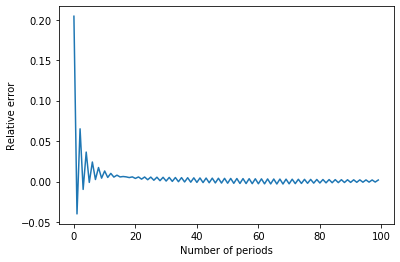

In [19]:
K = 105
err_list = []
for n in range(1,101):
    err_list.append(err(T, n, r, b, sigma, K))
plt.plot(err_list)
plt.xlabel("Number of periods")
plt.ylabel("Relative error")

As expected, the Black-Scholes model behaves as an asymptotic limit of the Cox-Ross-Rubenstein model as n goes to infinity, that is, in a continuous time setting.